# Fastsom on House Prices dataset

In this notebook, we'll train a Self-Organizing Map on a TabularDataBunch and use its weights as an input for a TabularModel trained on the same data.

Note: we assume data has already been downloaded. You can find the files [here](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [2]:
import torch
import numpy as np

from fastsom import *
from fastai_category_encoders import *
from fastai.tabular.all import *

## Importing the dataset

In [3]:
df_train = pd.read_csv('./nbs/data/train.csv')
df_test = pd.read_csv('./nbs/data/test.csv')

In [4]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
# Feature names
cat_names = [
    'MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
    'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
    'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 
    'Foundation', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir',
    'Electrical', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
    'PoolQC', 'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'BsmtQual', 'KitchenQual']
cont_names = [
    '1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr',
    'EnclosedPorch', 'Fireplaces', 'FullBath',
    'GarageYrBlt', 'GrLivArea', 'HalfBath', 'KitchenAbvGr', 
    'LotArea', 'LotFrontage', 'LowQualFinSF', 'MasVnrArea',
    'OpenPorchSF', 'PoolArea', 'ScreenPorch',
    'TotRmsAbvGrd', 'WoodDeckSF']
y_names = 'SalePrice'

df_train['SalePrice'] = df_train['SalePrice'].astype(float)

## Training the SOM

In order to work with categorical data, we use the `fastai_category_encoders` library to extend the Fast.ai Tabular API with the ability to train an unsupervised embedding model (e.g. FastText) on categorical features.

To do so, we can use the `TabularDataLoaders` class with the `CategoryEncode` proc:

In [6]:
# We are encoding categories by generating unsupervised embeddings
procs = [FillMissing, CategoryEncode('fasttext'), Normalize]
dls = TabularDataLoaders.from_df(df_train, cat_names=cat_names, cont_names=cont_names, y_names=y_names, procs=procs)

The `SomLearner` constructor is able to detect when the DataLoaders used contains a `CategoryEncode` proc, and will automatically add required callbacks and change the SOM distance function into `MixedEmbeddingDistance`.

In [7]:
learn = SomLearner(dls, size=(5,5), visualize=[SOM_TRAINING_VIZ.CODEBOOK_2D])
print(learn.model.dist_fn)
print(list(map(lambda cb: cb.__class__.__name__, learn.cbs)))

MixedEmbeddingDistance
['TrainEvalCallback', 'Recorder', 'ProgressCallback', 'SomTrainingVisualizationCallback', 'ExperimentalSomTrainer', 'UnifyDataCallback']


In [8]:
%matplotlib notebook
learn.fit(20)

epoch,train_loss,valid_loss,time
0,32.084488,15.716422,00:00
1,22.223604,14.793934,00:00
2,18.780134,14.470015,00:00
3,17.115572,14.394312,00:00
4,16.181408,14.344130,00:00
5,15.582362,14.294017,00:00
6,15.190615,14.177928,00:00
7,14.884601,14.085924,00:00
8,14.662943,13.979299,00:00
9,14.479307,13.886317,00:00


FigureWidget({
    'data': [{'marker': {'color': '#539dcc', 'size': 4},
              'mode': 'markers',
     …

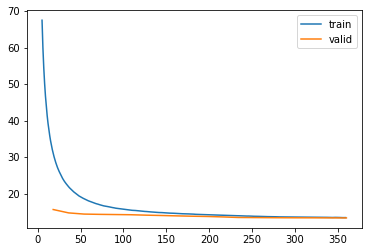

In [9]:
%matplotlib inline
learn.recorder.plot_loss()

## SOM Interpretation

The `SomInterpretation` class provides visualization utilities, to better understand the output of the training process.

In [10]:
interp = SomInterpretation.from_learner(learn)

`show_hitmap` displays a heatmap of hit counts for each map position:

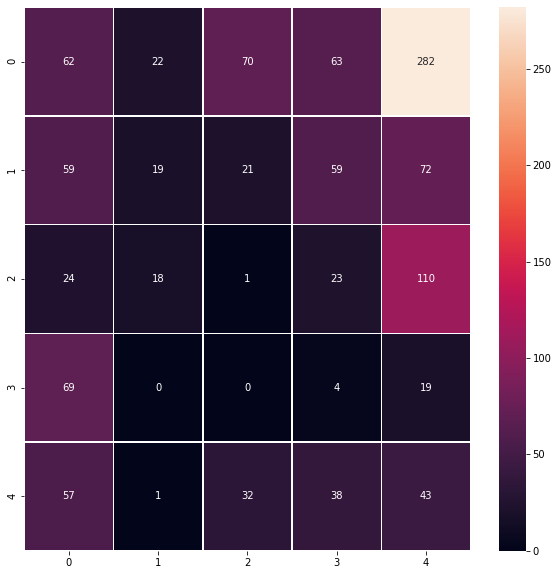

In [11]:
%matplotlib inline
interp.show_hitmap()

`show_feature_heatmaps` shows the per-feature value distribution over the SOM codebooks:

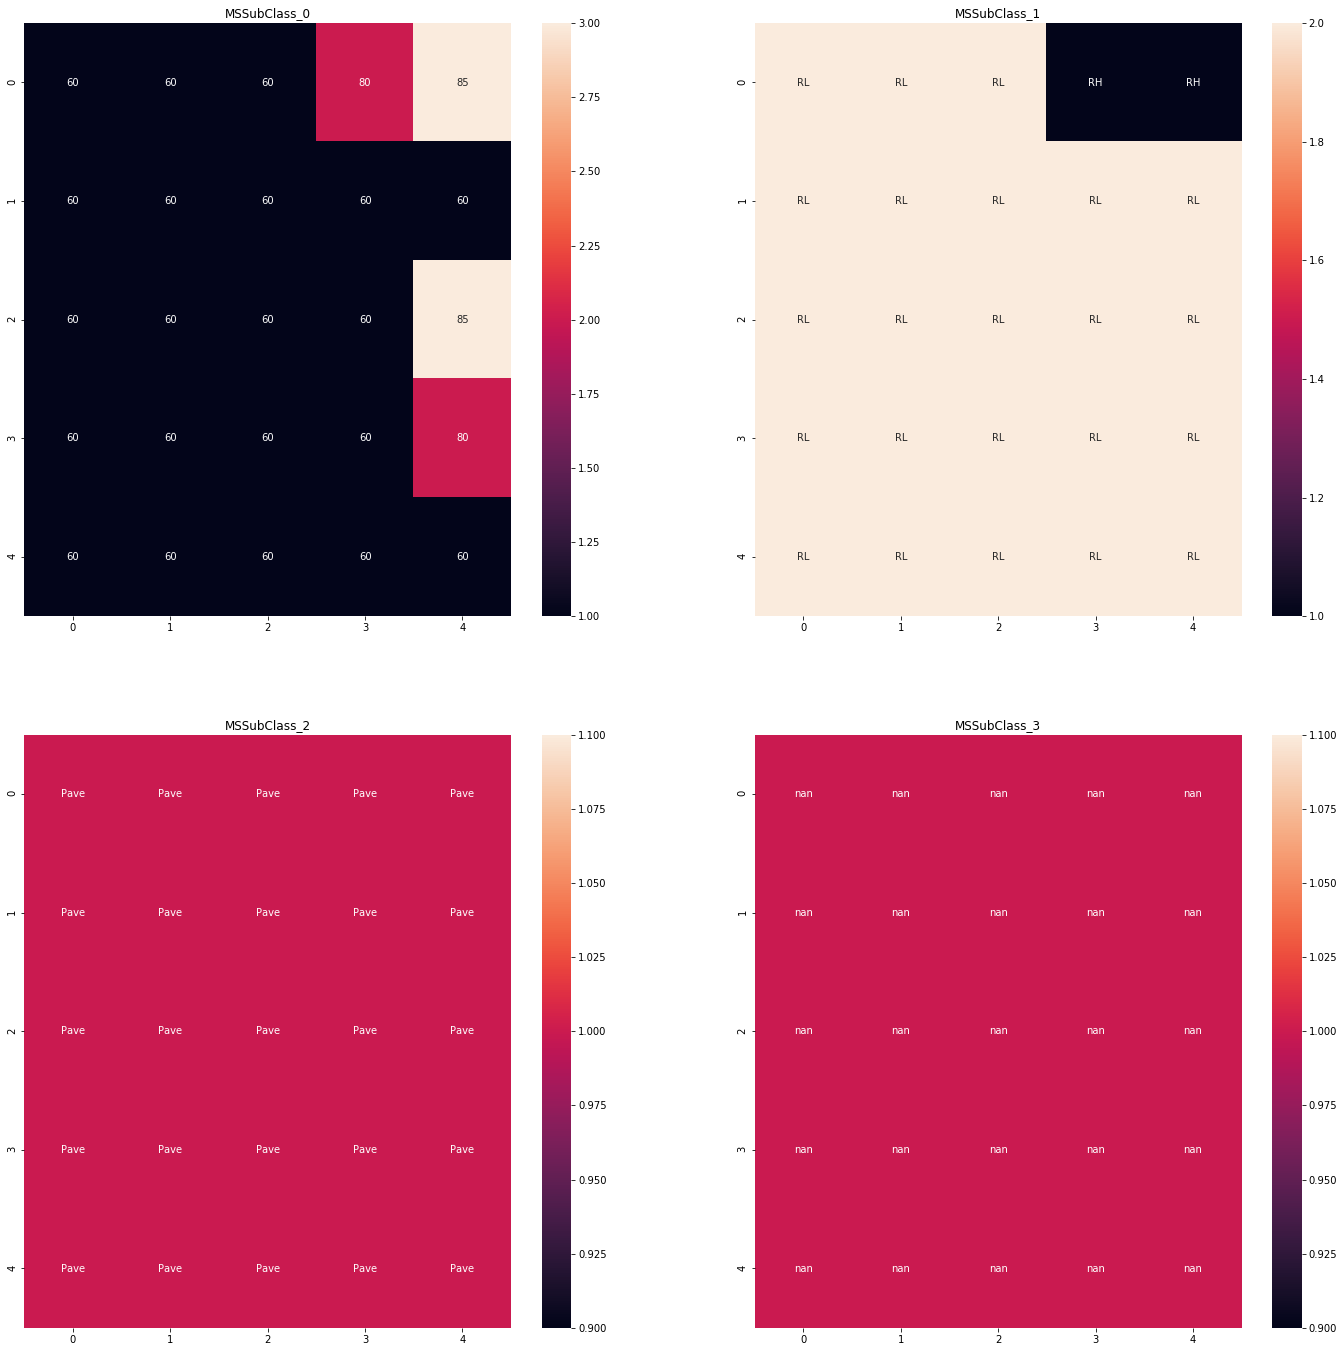

In [12]:
%matplotlib inline
interp.show_feature_heatmaps(feature_indices=[0, 1, 2, 3], recategorize=True)

`show_weights` displays a three-dimensional PCA of the SOM codebook as an RGB image:

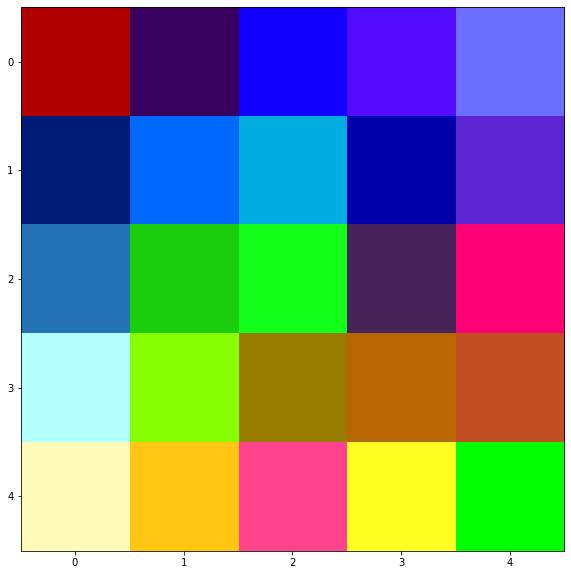

In [13]:
%matplotlib inline
interp.show_weights()

`show_preds` displays label distribution over the map, binning continuous values into `n_bins`:

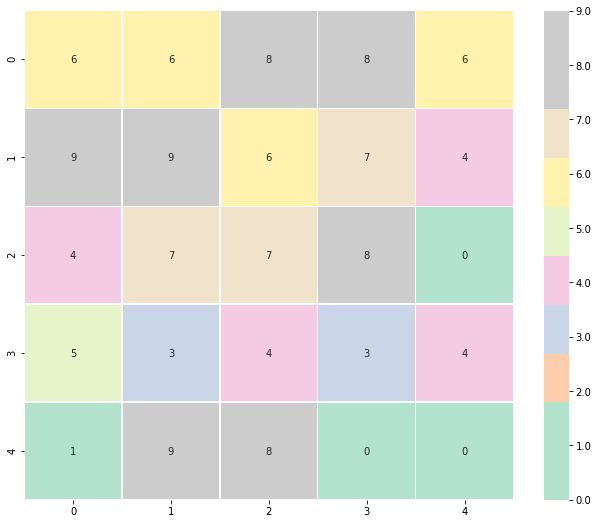

In [14]:
%matplotlib inline
interp.show_preds(n_bins=10)

In [15]:
learn.dls.train.ys.shape

(1168, 1)

## Training a Fastai Tabular model

Now that our SOM is trained, we can build a Tabular house price regressor and use it to visualize predictions over the map positions:

In [16]:
tab_procs = [FillMissing, Categorify, Normalize]
# create a logarithmic target to scale sale prices

max_log_y = np.log(np.max(df_train[y_names]) * 1.2)
y_range = torch.tensor([0, max_log_y], device='cuda:0')
df_train[y_names] = np.log(df_train[y_names])
# Create the tabular databunch
tabular_data = TabularDataLoaders.from_df(df_train, cat_names=cat_names, cont_names=cont_names, procs=tab_procs, y_names=y_names)
learn_tab = tabular_learner(tabular_data, layers=[200,100], y_range=y_range)

SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.0030199517495930195)

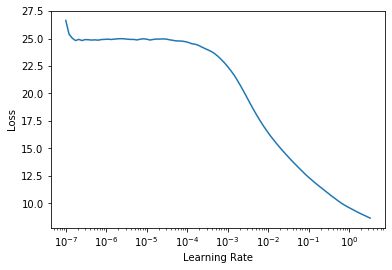

In [17]:
learn_tab.lr_find()

In [18]:
learn_tab.fit_one_cycle(4, lr_max=2e-2)

epoch,train_loss,valid_loss,time
0,6.235956,0.671320,00:00
1,3.214334,0.303829,00:00
2,1.998820,0.179956,00:00
3,1.336705,0.302101,00:00


The `SomLearner.codebook_to_df` method is useful to export the codebook values as a test dataset.

In [19]:
import matplotlib.pyplot as plt
# Create test dataset from SOM codebook
df_som = learn.codebook_to_df(recategorize=True, denorm=True)
df_som

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,LotFrontage,LowQualFinSF,MasVnrArea,OpenPorchSF,PoolArea,ScreenPorch,TotRmsAbvGrd,WoodDeckSF,som_row,som_col
0,60,RL,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,StoneBr,...,70.084062,7.475626,109.017529,54.739391,0.801948,15.375446,6.366686,99.191000,0,0
1,60,RL,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,Timber,...,69.348735,10.579675,110.554370,50.614789,4.701052,20.551819,6.433705,85.973658,0,1
2,60,RL,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,...,68.991682,3.975579,116.343207,46.219650,8.414882,20.147009,6.311718,82.675117,0,2
3,80,RH,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,...,70.155383,5.653587,97.662135,49.483597,5.476989,16.440704,6.478520,86.824912,0,3
4,85,RH,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,BrkSide,...,70.678238,8.391104,94.394066,52.082474,6.505827,16.845941,6.687236,94.541413,0,4
5,60,RL,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,Somerst,...,70.438737,3.847033,108.034893,42.643570,0.334989,19.408959,6.388966,83.894964,1,0
6,60,RL,Pave,nan,IR3,Lvl,AllPub,Inside,Gtl,StoneBr,...,70.389922,5.977781,107.184729,48.109416,2.041190,22.822036,6.534023,78.588612,1,1
7,60,RL,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,NPkVill,...,70.017759,4.697724,105.292419,54.823795,4.118075,19.024696,6.421376,79.404264,1,2
8,60,RL,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,...,69.835955,7.183572,91.107648,47.742786,2.974571,14.677835,6.390895,82.386720,1,3
9,60,RL,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,...,69.542762,8.551161,89.108425,46.692300,4.332513,13.891045,6.520755,89.116358,1,4


Now we can finally use the codebook DataFrame as a test set for the Tabular regressor; since we know the positional SOM encoding for each data point, we can then visualize a heatmap of predicted house prices:

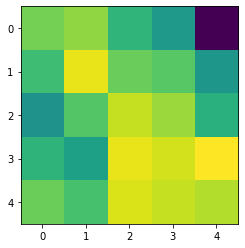

In [20]:
%matplotlib inline
dl_test = tabular_data.test_dl(df_som)

# Run tabular model predictions
preds, _ = learn_tab.get_preds(dl=dl_test)

# Display output
plt.imshow(preds.view(*(learn.model.size[:-1])))